# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve , auc, confusion_matrix, roc_auc_score
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('preprocessed_data.csv')
print(df.columns)
df = df.sample(n=10000,random_state=0).reset_index()

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')


In [3]:
df.drop('index',axis=1,inplace=True)
df.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,sc,ms,grades_6_8,4,1,music_arts,performingarts,it truly amazing arts integration school curri...,454.56
1,pa,ms,grades_3_5,1,1,math_science specialneeds,mathematics specialneeds,my students need chromebooks headphones utiliz...,67.27
2,ut,mrs,grades_3_5,3,1,music_arts,music performingarts,we 80 students every year third grade we schoo...,188.99
3,nc,mrs,grades_3_5,1,1,health_sports,gym_fitness health_wellness,i 20 amazing third graders eager learn our sch...,549.81
4,la,mrs,grades_prek_2,2,0,literacy_language,literacy,i teach 20 kindergarten children including esl...,1267.83


In [4]:
# Creating a reusable function
def three_way_splitter(x,y,test,cv):
#     First splitting train and test data
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=test,stratify=y)
#     Splitting train data into train and cv
    x_train, x_cv, y_train, y_cv = train_test_split(x_train,y_train, test_size=cv,stratify=y_train)  
    return x_train, x_cv, x_test, y_train, y_cv, y_test

In [5]:
label = df['project_is_approved'].values
df.drop('project_is_approved',axis=1,inplace=True)
# x_train,x_test,x_cv,y_train,y_test,y_cv = three_way_splitter(df, label,test=0.2,cv=0.1)
x_train, x_test, y_train, y_test = train_test_split(df,label,test_size=0.3,stratify=label)

In [6]:
# Defining reusable function

def encoder_for_cat_columns(col,train,test):
    if col == 'essay':
        cnt_vec = CountVectorizer(ngram_range=(1,5),min_df=10,max_features=10000)
    else:
        cnt_vec = CountVectorizer()
    
    print("Fitting the {:5} data to the count_vectorizer".format(col))
    cnt_vec.fit(train[col].values)
    print('Transforming the {:5} data'.format(col))
    return cnt_vec.transform(train[col].values), cnt_vec.transform(test[col].values)
# , cnt_vec.transform(cv[col].values)

def encoder_for_num_columns(col, train, test):
    normal = Normalizer()
    print('Fitting the {} column data to the normalizer'.format(col))
    normal.fit(train[col].values.reshape(-1,1))
    print('Fitting the {} column data to the normalizer'.format(col))
    return normal.transform(train[col].values.reshape(-1,1)) , normal.transform(test[col].values.reshape(-1,1))
# , normal.transform(cv[col].values.reshape(-1,1))


In [7]:
# Storing all the bow transformations in single dictionary
temp = {}
for ele in tqdm(df.columns):
    if type(df[ele][0] ) == str:
        temp_train , temp_test = encoder_for_cat_columns(ele,x_train,x_test)
        temp['x_train_{}_bow'.format(ele)] = temp_train
        del temp_train
        temp['x_test_{}_bow'.format(ele)]  = temp_test
        del temp_test
#         temp['x_cv_{}_bow'.format(ele)]    = temp_cv
#         del temp_cv
    else:
        temp_train , temp_test = encoder_for_num_columns(ele, x_train, x_test)
        temp['x_train_{}_norm '.format(ele)] = temp_train
        del temp_train
        temp['x_test_{}_norm'.format(ele)]  = temp_test
        del temp_test
#         temp['x_cv_{}_norm'.format(ele)]    = temp_cv
#         del temp_cv


  0%|          | 0/8 [00:00<?, ?it/s]

Fitting the school_state data to the count_vectorizer
Transforming the school_state data
Fitting the teacher_prefix data to the count_vectorizer


 25%|██▌       | 2/8 [00:00<00:00, 12.57it/s]

Transforming the teacher_prefix data
Fitting the project_grade_category data to the count_vectorizer
Transforming the project_grade_category data
Fitting the teacher_number_of_previously_posted_projects column data to the normalizer
Fitting the teacher_number_of_previously_posted_projects column data to the normalizer
Fitting the clean_categories data to the count_vectorizer
Transforming the clean_categories data


 62%|██████▎   | 5/8 [00:00<00:00, 12.57it/s]

Fitting the clean_subcategories data to the count_vectorizer
Transforming the clean_subcategories data
Fitting the essay data to the count_vectorizer
Transforming the essay data


100%|██████████| 8/8 [00:29<00:00,  3.71s/it]

Fitting the price column data to the normalizer
Fitting the price column data to the normalizer


In [8]:
hstack_temp = {}
for ele in tqdm(['train','test']):
    hstack_temp[ele] = []
    for key in temp.keys():
        if key.find(ele) >=0:
            hstack_temp[ele].append(temp[key])
del temp

100%|██████████| 2/2 [00:00<00:00, 14463.12it/s]


In [9]:
x_tr = hstack(hstack_temp['train']).tocsr()
x_te = hstack(hstack_temp['test']).tocsr()
# x_cv = hstack(hstack_temp['cv']).tocsr()
del hstack_temp

In [10]:
x_tr.shape

(7000, 10100)

In [11]:
x_te.shape

(3000, 10100)

In [12]:
mnb = MultinomialNB()
parameters = {'alpha':[10**-5,10**-4 ,10**-3,10**-2,10**-1,1,1.5,2,5,10,15,20,40,80,100,120]}
clf = GridSearchCV(mnb,parameters,cv=5,scoring='roc_auc',return_train_score=True)
clf.fit(x_tr.toarray(),y_train)
results = pd.DataFrame(clf.cv_results_)
results.sort_values('param_alpha',inplace=True)

In [13]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.285558,0.013140,0.029250,0.000812,1e-05,{'alpha': 1e-05},0.654408,0.618793,0.639399,0.637966,...,0.633919,0.013548,10,0.967961,0.964148,0.959545,0.961058,0.961996,0.962942,0.002920
1,0.282466,0.002287,0.029851,0.001509,0.0001,{'alpha': 0.0001},0.665327,0.627061,0.650705,0.645884,...,0.644472,0.013436,8,0.966835,0.962704,0.958108,0.959612,0.960686,0.961589,0.003020
2,0.291983,0.010163,0.031579,0.005577,0.001,{'alpha': 0.001},0.675610,0.639346,0.656506,0.656456,...,0.654141,0.012810,7,0.964952,0.960658,0.956025,0.957401,0.958678,0.959543,0.003105
3,0.283190,0.010033,0.029987,0.001462,0.01,{'alpha': 0.01},0.685918,0.648767,0.664242,0.663564,...,0.663385,0.012673,5,0.961812,0.957548,0.952824,0.953977,0.955436,0.956319,0.003168
4,0.282840,0.001971,0.029388,0.000311,0.1,{'alpha': 0.1},0.695336,0.659322,0.669738,0.669010,...,0.671855,0.012308,4,0.956041,0.952151,0.947182,0.947846,0.949611,0.950566,0.003233


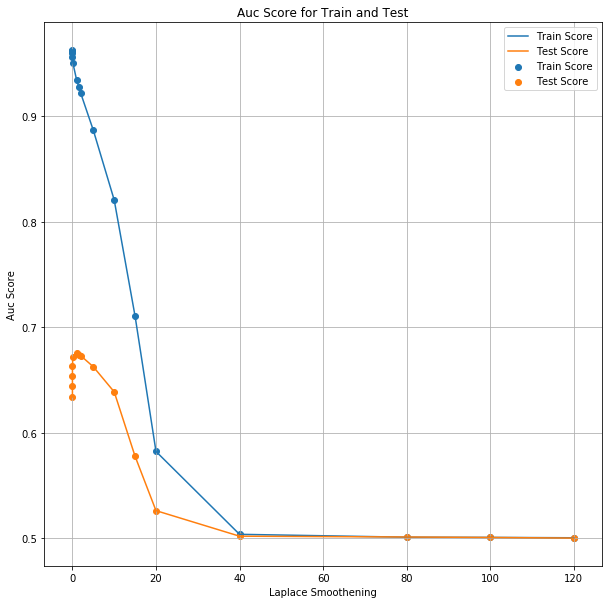

In [14]:
fig , ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(results['param_alpha'],results['mean_train_score'],label='Train Score')
ax.scatter(results['param_alpha'],results['mean_train_score'],label='Train Score')
ax.plot(results['param_alpha'],results['mean_test_score'],label='Test Score')
ax.scatter(results['param_alpha'],results['mean_test_score'],label='Test Score')
ax.set_ylabel('Auc Score')
ax.set_xlabel('Laplace Smoothening')
ax.legend()
ax.grid()
# ax.set_xticks(map(str,results['param_alpha']))
ax.set_title('Auc Score for Train and Test')
plt.show()

In [15]:
print('Alpha','Train Score','Test Score','Distance',sep=' ==> ')
for ind, row in results.iterrows():
    print(row.param_alpha,row.mean_train_score,row.mean_test_score,row.mean_train_score-row.mean_test_score,sep=' ==> ')

Alpha ==> Train Score ==> Test Score ==> Distance
1e-05 ==> 0.9629416059274025 ==> 0.6339185147479786 ==> 0.32902309117942397
0.0001 ==> 0.961589240639835 ==> 0.6444718849580884 ==> 0.3171173556817466
0.001 ==> 0.9595429162761915 ==> 0.6541405008927993 ==> 0.3054024153833922
0.01 ==> 0.9563193161107751 ==> 0.663384531857187 ==> 0.2929347842535881
0.1 ==> 0.9505661721087643 ==> 0.6718551773696393 ==> 0.278710994739125
1 ==> 0.9344111347586999 ==> 0.6751302886403512 ==> 0.2592808461183487
1.5 ==> 0.9278105751002208 ==> 0.674127679679204 ==> 0.25368289542101685
2 ==> 0.9216266691410013 ==> 0.6729947565517246 ==> 0.24863191258927675
5 ==> 0.8867315165048926 ==> 0.6625275052742371 ==> 0.22420401123065548
10 ==> 0.8206032154977265 ==> 0.638738192136785 ==> 0.18186502336094157
15 ==> 0.7103963205751476 ==> 0.5776152778406894 ==> 0.13278104273445812
20 ==> 0.5822695285783884 ==> 0.526161494576872 ==> 0.05610803400151643
40 ==> 0.5037153601772809 ==> 0.5019444859446021 ==> 0.001770874232678854


In [16]:
# Taking the best alpha
alpha = 0.01

In [17]:
mnb = MultinomialNB(alpha=alpha)
mnb.fit(x_tr.toarray(),y_train)
y_te_predict = mnb.predict(x_te.toarray())
y_tr_predict = mnb.predict(x_tr.toarray())

In [18]:
print(roc_auc_score(y_train,y_tr_predict))
print(roc_auc_score(y_test,y_te_predict))

0.8455277344304155
0.5808093346573981


In [19]:
train_fpr , train_tpr , tr_thresholds = roc_curve(y_train,y_tr_predict)
test_fpr , test_tpr , te_threshokds = roc_curve(y_test,y_te_predict)

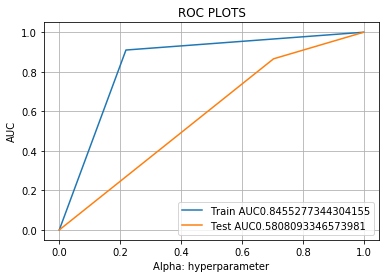

In [20]:
plt.plot(train_fpr,train_tpr, label='Train AUC'+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label='Test AUC'+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

In [21]:
te_conf = confusion_matrix(y_test,y_te_predict)
tr_conf = confusion_matrix(y_train,y_tr_predict)

In [22]:
te_conf

array([[ 135,  321],
       [ 342, 2202]])

In [23]:
tr_conf

array([[ 831,  233],
       [ 534, 5402]])

# TFIDF implementation

In [24]:
def tf_encoder_for_cat_columns(col,train,test):
    if col == 'essay':
        vec = TfidfVectorizer(ngram_range=(1,4),min_df=10,norm='l1',max_features=10000)
    else:
        vec = CountVectorizer()
    
    print("Fitting the {:5} data to the count_vectorizer".format(col))
    vec.fit(train[col].values)
    print('Transforming the {:5} data'.format(col))
    return vec.transform(train[col].values), vec.transform(test[col].values)
# , cnt_vec.transform(cv[col].values)

def encoder_for_num_columns(col, train, test):
    normal = Normalizer()
    print('Fitting the {} column data to the normalizer'.format(col))
    normal.fit(train[col].values.reshape(-1,1))
    print('Fitting the {} column data to the normalizer'.format(col))
    return normal.transform(train[col].values.reshape(-1,1)) , normal.transform(test[col].values.reshape(-1,1))
# , normal.transform(cv[col].values.reshape(-1,1))


In [25]:
# Storing all the bow transformations in single dictionary
temp = {}
for ele in tqdm(df.columns):
    if type(df[ele][0] ) == str:
        temp_train , temp_test = tf_encoder_for_cat_columns(ele,x_train,x_test)
        temp['x_train_{}_tfidf'.format(ele)] = temp_train
        del temp_train
        temp['x_test_{}_tfidf'.format(ele)]  = temp_test
        del temp_test
#         temp['x_cv_{}_bow'.format(ele)]    = temp_cv
#         del temp_cv
    else:
        temp_train , temp_test = encoder_for_num_columns(ele, x_train, x_test)
        temp['x_train_{}_norm '.format(ele)] = temp_train
        del temp_train
        temp['x_test_{}_norm'.format(ele)]  = temp_test
        del temp_test
#         temp['x_cv_{}_norm'.format(ele)]    = temp_cv
#         del temp_cv


 38%|███▊      | 3/8 [00:00<00:00, 28.61it/s]

Fitting the school_state data to the count_vectorizer
Transforming the school_state data
Fitting the teacher_prefix data to the count_vectorizer
Transforming the teacher_prefix data
Fitting the project_grade_category data to the count_vectorizer
Transforming the project_grade_category data
Fitting the teacher_number_of_previously_posted_projects column data to the normalizer
Fitting the teacher_number_of_previously_posted_projects column data to the normalizer
Fitting the clean_categories data to the count_vectorizer
Transforming the clean_categories data
Fitting the clean_subcategories data to the count_vectorizer
Transforming the clean_subcategories data
Fitting the essay data to the count_vectorizer
Transforming the essay data


100%|██████████| 8/8 [00:18<00:00,  2.32s/it]

Fitting the price column data to the normalizer
Fitting the price column data to the normalizer


In [26]:
hstack_temp = {}
for ele in tqdm(['train','test']):
    print('='*50)
    print('Creating seperate key val pairs for hstacking')
    hstack_temp[ele] = []
    for key in temp.keys():
        if key.find(ele) >=0:
            print(key)
            hstack_temp[ele].append(temp[key])
del temp

100%|██████████| 2/2 [00:00<00:00, 4337.44it/s]

Creating seperate key val pairs for hstacking
x_train_school_state_tfidf
x_train_teacher_prefix_tfidf
x_train_project_grade_category_tfidf
x_train_teacher_number_of_previously_posted_projects_norm 
x_train_clean_categories_tfidf
x_train_clean_subcategories_tfidf
x_train_essay_tfidf
x_train_price_norm 
Creating seperate key val pairs for hstacking
x_test_school_state_tfidf
x_test_teacher_prefix_tfidf
x_test_project_grade_category_tfidf
x_test_teacher_number_of_previously_posted_projects_norm
x_test_clean_categories_tfidf
x_test_clean_subcategories_tfidf
x_test_essay_tfidf
x_test_price_norm


In [27]:
x_tr = hstack(hstack_temp['train']).tocsr()
x_te = hstack(hstack_temp['test']).tocsr()
# x_cv = hstack(hstack_temp['cv']).tocsr()
del hstack_temp

In [28]:
x_tr.shape

(7000, 10100)

In [29]:
x_te.shape

(3000, 10100)

In [30]:
gnb = MultinomialNB()
parameters = {'alpha':[10**-5,10**-4 ,10**-3,10**-2,10**-1,1,1.5,2,5,10,15,20,40,80,100,120]}
clf = GridSearchCV(gnb,parameters,cv=5,scoring='roc_auc',return_train_score=True)
clf.fit(x_tr.toarray(),y_train)
results = pd.DataFrame(clf.cv_results_)
results.sort_values('param_alpha',inplace=True)

In [31]:
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.272804,0.027634,0.029280,0.000517,1e-05,{'alpha': 1e-05},0.568913,0.573173,0.548244,0.586756,...,0.567068,0.013118,1,0.745434,0.742779,0.741979,0.733473,0.740562,0.740846,0.004013
1,0.284320,0.000849,0.030541,0.002259,0.0001,{'alpha': 0.0001},0.566696,0.573478,0.544625,0.584165,...,0.565213,0.013560,2,0.734103,0.730961,0.731012,0.722315,0.729198,0.729518,0.003932
2,0.284996,0.002153,0.029717,0.000434,0.001,{'alpha': 0.001},0.563977,0.574127,0.540851,0.580930,...,0.562964,0.014156,3,0.720399,0.716642,0.717836,0.708882,0.715605,0.715873,0.003844
3,0.285341,0.000875,0.029517,0.000095,0.01,{'alpha': 0.01},0.560748,0.572576,0.535140,0.576164,...,0.559249,0.014869,4,0.695747,0.691358,0.694370,0.685031,0.691876,0.691676,0.003691
4,0.286524,0.002638,0.029637,0.000630,0.1,{'alpha': 0.1},0.557603,0.568020,0.530849,0.571358,...,0.555278,0.014617,5,0.648993,0.646242,0.650849,0.641304,0.649218,0.647321,0.003353
5,0.283218,0.003363,0.029449,0.000141,1,{'alpha': 1},0.560859,0.550154,0.548006,0.556253,...,0.553770,0.004534,6,0.588250,0.593464,0.592688,0.589051,0.592295,0.591149,0.002090
6,0.286075,0.001417,0.029739,0.000316,1.5,{'alpha': 1.5},0.559839,0.545135,0.549347,0.552618,...,0.551535,0.004829,7,0.579028,0.584811,0.582889,0.580335,0.582852,0.581983,0.002051
7,0.286536,0.002673,0.029653,0.001024,2,{'alpha': 2},0.558832,0.541654,0.549707,0.550336,...,0.549825,0.005472,8,0.573426,0.579446,0.577001,0.574905,0.577197,0.576395,0.002066
8,0.286151,0.001361,0.029875,0.000533,5,{'alpha': 5},0.555204,0.532897,0.551072,0.544688,...,0.545550,0.007581,9,0.560214,0.566849,0.562628,0.562414,0.563491,0.563119,0.002156
9,0.285371,0.002091,0.029600,0.000106,10,{'alpha': 10},0.553236,0.528503,0.549810,0.539914,...,0.542602,0.008628,10,0.552516,0.559946,0.554708,0.555632,0.556257,0.555812,0.002425


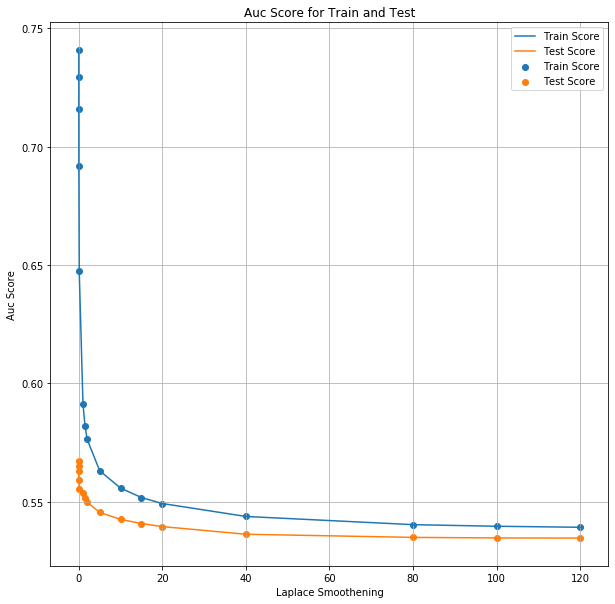

In [32]:
fig , ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(results['param_alpha'],results['mean_train_score'],label='Train Score')
ax.scatter(results['param_alpha'],results['mean_train_score'],label='Train Score')
ax.plot(results['param_alpha'],results['mean_test_score'],label='Test Score')
ax.scatter(results['param_alpha'],results['mean_test_score'],label='Test Score')
ax.set_ylabel('Auc Score')
ax.set_xlabel('Laplace Smoothening')
ax.legend()
ax.grid()
# ax.set_xticks(map(str,results['param_alpha']))
ax.set_title('Auc Score for Train and Test')
plt.show()

In [33]:
print('Alpha','Train Score','Test Score','Distance',sep=' ==> ')
for ind, row in results.iterrows():
    print(row.param_alpha,row.mean_train_score,row.mean_test_score,row.mean_train_score-row.mean_test_score,sep=' ==> ')

Alpha ==> Train Score ==> Test Score ==> Distance
1e-05 ==> 0.7408455554517868 ==> 0.5670684282395282 ==> 0.17377712721225858
0.0001 ==> 0.7295180089059844 ==> 0.5652133646125647 ==> 0.16430464429341973
0.001 ==> 0.7158729762011675 ==> 0.5629635649262862 ==> 0.15290941127488133
0.01 ==> 0.6916763903486189 ==> 0.5592494390415849 ==> 0.13242695130703408
0.1 ==> 0.6473211952312009 ==> 0.5552784279385407 ==> 0.09204276729266025
1 ==> 0.5911494901740283 ==> 0.5537698642124945 ==> 0.03737962596153377
1.5 ==> 0.581983060278036 ==> 0.5515345129490856 ==> 0.030448547328950415
2 ==> 0.5763949502380905 ==> 0.5498249765547828 ==> 0.026569973683307713
5 ==> 0.5631191437442122 ==> 0.5455496925614849 ==> 0.017569451182727347
10 ==> 0.5558118624160775 ==> 0.5426020383370872 ==> 0.013209824078990295
15 ==> 0.5518156172339527 ==> 0.5408571719712189 ==> 0.010958445262733818
20 ==> 0.5492955606904728 ==> 0.5395601450553227 ==> 0.009735415635150124
40 ==> 0.5438377409725602 ==> 0.5363293655616383 ==> 0.007

In [34]:
alpha = 0.001

In [35]:
mnb = MultinomialNB(alpha=alpha)
mnb.fit(x_tr.toarray(),y_train)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [36]:
y_te_predict = mnb.predict(x_te.toarray())
y_tr_predict = mnb.predict(x_tr.toarray())

In [37]:
print(roc_auc_score(y_train,y_tr_predict))
print(roc_auc_score(y_test,y_te_predict))

0.5014097744360902
0.5


In [38]:
train_fpr , train_tpr , tr_thresholds = roc_curve(y_train,y_tr_predict)
test_fpr , test_tpr , te_threshokds = roc_curve(y_test,y_te_predict)

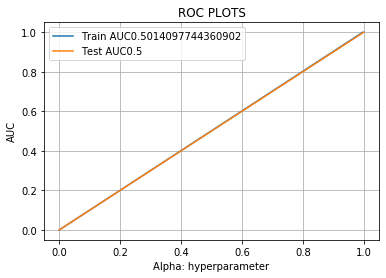

In [39]:
plt.plot(train_fpr,train_tpr, label='Train AUC'+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label='Test AUC'+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

In [40]:
te_conf = confusion_matrix(y_test,y_te_predict)
tr_conf = confusion_matrix(y_train,y_tr_predict)

In [41]:
te_conf

array([[   0,  456],
       [   0, 2544]])

In [42]:
tr_conf

array([[   3, 1061],
       [   0, 5936]])